In [61]:
import carla_experiments.common.position_and_rotation as pr
import numpy as np
import carla
import matplotlib.pyplot as plt
import torch
import pandas as pd
import cv2
from pathlib import Path
from PIL import Image
from carla_experiments.models.op_deepdive import SequenceBaselineV1
from carla_experiments.common.utils_op_deepdive import transform_images, setup_calling_op_deepdive, opd_input_images_to_rgb, plot_trajectory, plot_trajectory_with_colors
from carla_experiments.common.position_and_rotation import ecef_frd_quaternion_to_carla_rotation, ecef_to_carla_location, carla_location_to_ecef, carla_location_to_ecef2
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DEVICE = "cuda"

In [49]:
comma_seg = Path("/home/ulrikro/datasets/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-07-30--13-03-07/14/")
carla_seg = Path("./output/big_boy/carla2k19/Chunk_1/Batch_1/Segment_1/")
pure_carla_seg = Path("./output/pure_carla/carla2k19/Chunk_1/batch1/1/")

In [6]:
def load_video_frames(path: Path):
    frames = []
    video = cv2.VideoCapture(str(path / "video.hevc"))
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frames.append(image)
    return frames

In [7]:
def remove_z(point: np.ndarray):
    return [point[0], point[1], 0]

In [8]:
def load_op_deepdive_model(ckpt_path: str):
    model = SequenceBaselineV1(5, 33, 1.0, 0.0, "adamw")
    model.load_state_dict(torch.load(ckpt_path))
    model.to(DEVICE)
    model.eval()
    # planning_v0.eval().cuda()
    # model, *_ = load_state_dict(model, None, "./.weights/agentB0/091148-loss0.0007.pt")
    return model

In [38]:
pure_frames = load_video_frames(pure_carla_seg)
pure_positions = np.load(pure_carla_seg / "global_pose/frame_positions")
pure_orientations = np.load(pure_carla_seg / "global_pose/frame_orientations")

In [50]:
carla_frames = load_video_frames(carla_seg)

In [52]:
carla_positions = np.load(carla_seg / "global_pose/frame_positions") 
carla_orientations = np.load(carla_seg / "global_pose/frame_orientations")

In [12]:
comma_frames = load_video_frames(comma_seg)
comma_positions = np.load(comma_seg / "global_pose/frame_positions")
comma_orientations = np.load(comma_seg / "global_pose/frame_orientations")

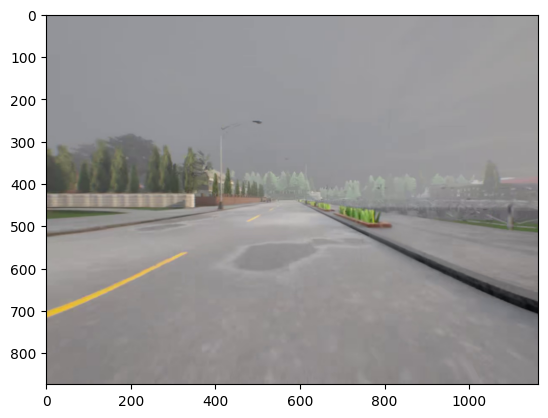

In [13]:
plt.imshow(carla_frames[1])
plt.show()

In [14]:
comma_model = load_op_deepdive_model("./.weights/comma_epoch_99.pth")
call_comma_model = setup_calling_op_deepdive(comma_model, batch_size=1, device=DEVICE)


Loaded pretrained weights for efficientnet-b2


In [15]:
carla_model = load_op_deepdive_model("./.weights/carla_epoch_99.pth")
call_carla_model = setup_calling_op_deepdive(carla_model, batch_size=1, device=DEVICE)

Loaded pretrained weights for efficientnet-b2


# Comma2k19 model

In [16]:
frame_index = 1
input_images = transform_images(comma_frames[frame_index], comma_frames[frame_index-1], DEVICE)
input_images.size()

torch.Size([1, 6, 128, 256])

In [17]:
pred_trajectories, pred_conf, *_ = call_comma_model(input_images)
most_confident_trajectory = pred_trajectories[pred_conf.argmax(), :]

In [18]:
most_confident_trajectory

tensor([[ 6.1444e-01, -4.4534e-04,  5.1382e-03],
        [ 6.9562e-01, -1.8866e-03,  1.0636e-03],
        [ 1.0080e+00,  1.1081e-02, -1.2117e-02],
        [ 1.4044e+00,  4.0857e-02, -3.1357e-02],
        [ 1.7961e+00,  4.9113e-02, -6.7707e-02],
        [ 2.1803e+00,  7.8806e-02, -1.0413e-01],
        [ 2.5320e+00,  1.1349e-01, -1.4650e-01],
        [ 2.8804e+00,  1.5149e-01, -1.8846e-01],
        [ 3.2461e+00,  2.0880e-01, -2.3589e-01],
        [ 3.5248e+00,  2.5394e-01, -3.1386e-01],
        [ 3.8221e+00,  3.0447e-01, -3.7757e-01],
        [ 4.2061e+00,  3.8593e-01, -4.4557e-01],
        [ 4.4554e+00,  4.5362e-01, -5.3119e-01],
        [ 4.7786e+00,  5.1104e-01, -6.0580e-01],
        [ 5.1072e+00,  5.7845e-01, -7.0877e-01],
        [ 5.4413e+00,  6.4933e-01, -7.8715e-01],
        [ 5.7674e+00,  7.1145e-01, -8.8760e-01],
        [ 6.0511e+00,  7.7842e-01, -9.9868e-01],
        [ 6.3483e+00,  8.3250e-01, -1.0878e+00],
        [ 6.5889e+00,  8.9374e-01, -1.1916e+00],
        [ 6.8475e+00

In [19]:
curr, last = opd_input_images_to_rgb(input_images.cpu())

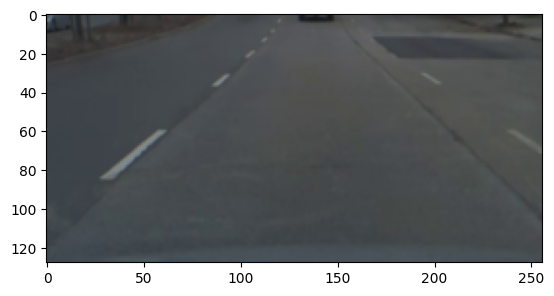

In [20]:
plt.imshow(curr)
plt.show()

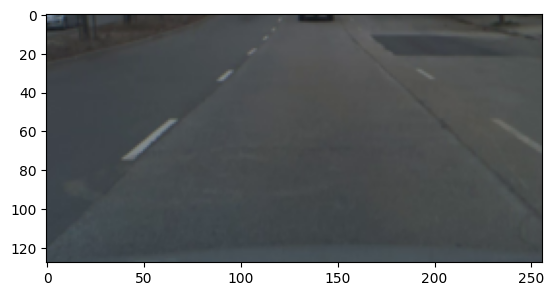

In [21]:
plt.imshow(last)
plt.show()

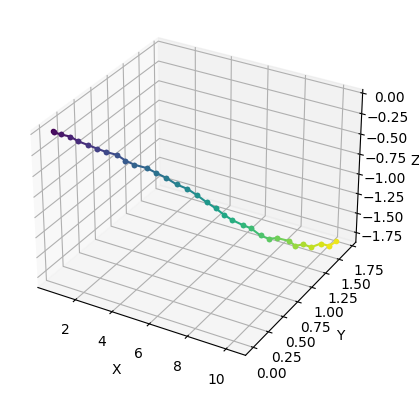

In [22]:
plot_trajectory_with_colors(most_confident_trajectory.cpu().numpy(), show=True, save_path=None)

In [23]:
# Actual predicted trajectory
def get_actual_predicted_trajectory(model, frames):
    # This does not really represent things well
    starting_point = np.array([0, 0, 0])
    trajectory = [starting_point]
    for i in tqdm(range(1, len(frames))):
        input_images = transform_images(frames[i], frames[i-1], DEVICE)
        pred_trajectories, pred_conf, *_ = model(input_images)
        most_confident_trajectory = pred_trajectories[pred_conf.argmax(), :].cpu().numpy()
        next_relative_waypoint = most_confident_trajectory[1]
        last_waypoint = trajectory[-1]
        next_waypoint = last_waypoint + next_relative_waypoint
        trajectory.append(next_waypoint)
    return np.array(trajectory)

In [24]:
len(comma_frames)

1201

In [25]:
comma_trajectory = get_actual_predicted_trajectory(call_comma_model, comma_frames)

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [01:42<00:00, 11.66it/s]


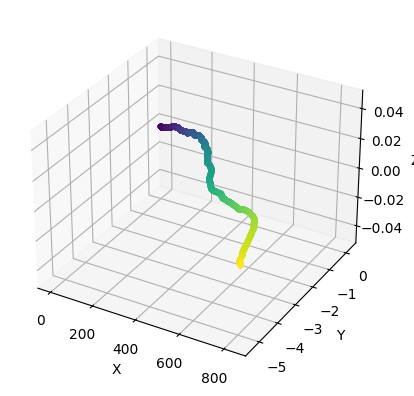

In [26]:
plot_trajectory_with_colors(np.array([remove_z(item) for item in comma_trajectory]), show=True, save_path=None)

In [27]:
print(comma_trajectory[0], comma_trajectory[100], comma_trajectory[-1])

[0. 0. 0.] [45.22852787  0.13169126  0.42121097] [833.86092958  -5.3236317    4.05974281]


In [28]:

# [0. 0. 0.] [-29.479456   -40.15566427 -66.49503508] [-158.03341409 -215.38491357 -330.34185087]

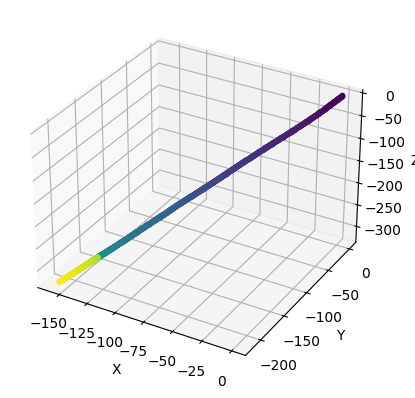

In [29]:
actual_trajectory = comma_positions - comma_positions[0]
plot_trajectory_with_colors(actual_trajectory, show=True, save_path=None)

In [30]:
print(actual_trajectory[0], actual_trajectory[100], actual_trajectory[-1])

[0. 0. 0.] [-29.479456   -40.15566427 -66.49503508] [-158.03341409 -215.38491357 -330.34185087]


In [31]:
carla_trajectory = get_actual_predicted_trajectory(call_carla_model, carla_frames)


  0%|          | 0/1199 [00:00<?, ?it/s]

100%|██████████| 1199/1199 [01:39<00:00, 11.99it/s]


In [32]:
len(carla_frames)

1200

Does the path become more scuffed the further into the segments we get?

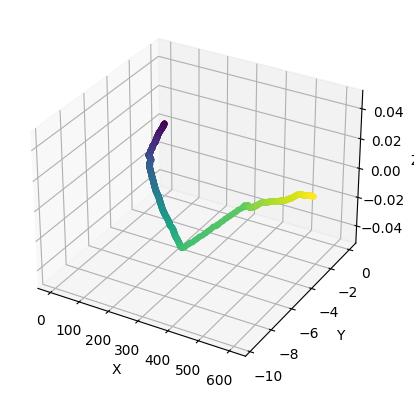

In [33]:
plot_trajectory_with_colors(np.array([remove_z(item) for item in carla_trajectory]), show=True, save_path=None)

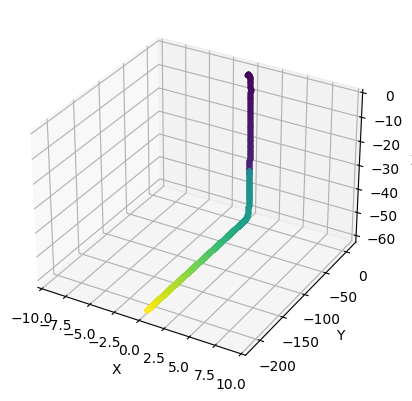

In [74]:
actual_carla_trajectory = np.array([item for item in (carla_positions - carla_positions[0])])
# x = actual_carla_trajectory[:, 0]
# y = actual_carla_trajectory[:, 2]
# plt.plot(x, y)
# plt.show()

plot_trajectory_with_colors(actual_carla_trajectory, show=True, save_path=None, xlim=(-10, 10))

In [82]:
def transform_from_ego_frame_to_map_coordinates(
    ego_trans: carla.Transform, waypoint: np.ndarray
) -> carla.Location:
    # IS THIS CORRECT? SHOULDN'T IT JUST ADD THE WAYPOINT TO THE EGO LOCATION?
    fu_c = ego_trans.get_forward_vector().make_unit_vector()
    forward_unit_vec = np.array((fu_c.x, fu_c.y, fu_c.z))
    ru_c = ego_trans.get_right_vector().make_unit_vector()
    right_unit_vec = np.array((ru_c.x, ru_c.y, ru_c.z))
    up = ego_trans.get_up_vector().make_unit_vector()
    up_unit_vec = np.array((up.x, up.y, up.z))

    ego_l = np.array((ego_trans.location.x, ego_trans.location.y, ego_trans.location.z))
    # This neglects the z coordinate
    print("vecs", forward_unit_vec, right_unit_vec, up_unit_vec)
    target_l = (
        ego_l
        + waypoint[0] * forward_unit_vec
        + waypoint[1] * right_unit_vec
        + waypoint[2] * up_unit_vec
    )
    # print("trans loc and rot", ego_l)
    # print("trans_matrix", ego_trans.get_matrix())
    return target_l

def transform_from_ego_frame_to_map_coordinates2(ego_trans: carla.Transform, waypoint: np.ndarray):
    # This is wrong, because waypoint is not converted to absolute before addition
    ego_l = np.array((ego_trans.location.x, ego_trans.location.y, ego_trans.location.z))
    # convert waypoint from 
    return ego_l + waypoint


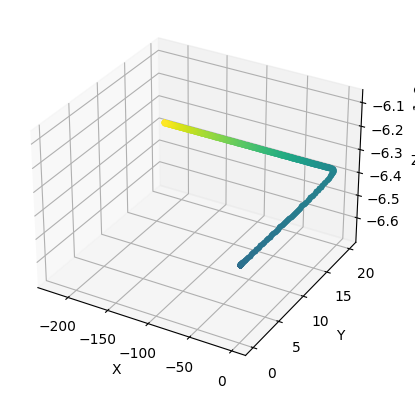

In [63]:
# convert back to carla
def load_carla_map():
    with open("/home/ulrikro/code/Carla2/CARLA_0.9.15/CarlaUE4/Content/Carla/Maps/OpenDrive/Town01.xodr", "r") as file:
        data = file.read()
        return carla.Map("Town01", data)

carla_map = load_carla_map()
carla_original_locations = [ecef_to_carla_location(carla_map, item) for item in actual_carla_trajectory]
carla_original_numpy = np.array([[item.x, item.y, item.z] for item in carla_original_locations])
# plt.plot(x, y)
plot_trajectory_with_colors(carla_original_numpy, show=True, save_path=None)

In [99]:
pure_location = ecef_to_carla_location(carla_map, carla_positions[4])
pure_rotation = ecef_frd_quaternion_to_carla_rotation(carla_map, carla_orientations[4])
pure_transform = carla.Transform(pure_location, pure_rotation)
predicted_waypoint = carla_trajectory[4]
print("loc", carla_positions[4], carla_orientations[4])
one = transform_from_ego_frame_to_map_coordinates(pure_transform, predicted_waypoint)
one

loc [ 6.37813700e+06  3.28145844e+02 -1.33713531e+02] [ 0.47752719 -0.52121921 -0.47853896  0.5208635 ]
vecs [ 9.99998868e-01 -5.96673635e-04  1.39442238e-03] [ 7.14299676e-04  9.96300280e-01 -8.59372318e-02] [-0.00133799  0.08593813  0.99629956]


array([ 3.29620767e+02,  1.33682852e+02, -3.54472356e-02])

In [98]:
two = transform_from_ego_frame_to_map_coordinates2(pure_transform, predicted_waypoint)
two

array([ 3.29620732e+02,  1.33687218e+02, -3.99194285e-02])

In [100]:
one == two

array([False, False, False])

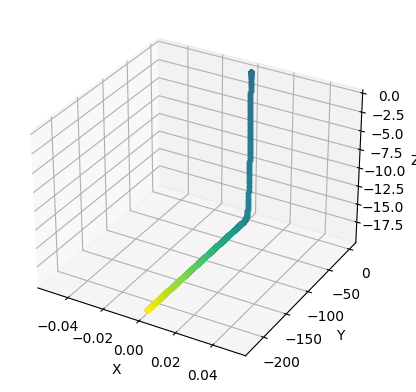

In [64]:
carla_original_to_ecef = np.array([carla_location_to_ecef(carla_map, item) for item in carla_original_locations])
plot_trajectory_with_colors(carla_original_to_ecef, show=True, save_path=None)

In [35]:
actual_carla_trajectory.shape

(1000, 3)

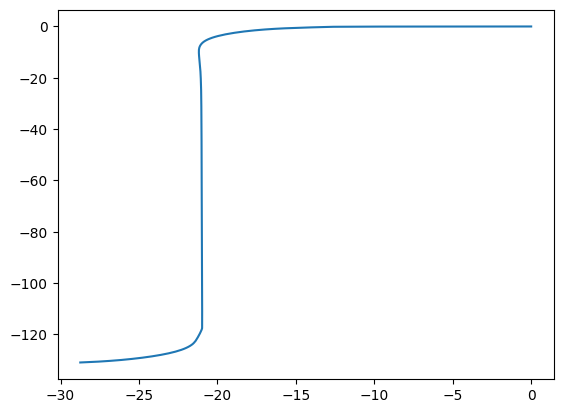

In [42]:
pure_trajectory = np.array([remove_z(item) for item in (pure_positions[200:] - pure_positions[200])])
x = pure_trajectory[:, 0]
y = pure_trajectory[:, 1]
plt.plot(x, y)
plt.show()
# plot_trajectory(pure_trajectory, show=True, save_path=None)